## Package Installation and device checking

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

## Interleaving Tokenization Method (Garg et al., 2022)

We consider an alternative tokenization method called **Interleave**, where the features `x` and `y` are interleaved into separate tokens.

### Tokenization Process:
E(P) =
\begin{pmatrix}
x_1 & 0 & x_2 & 0 & \cdots & x_N & 0 & x_{query} \\
0 & y_1 & 0 & y_2 & \cdots & 0 & y_N & 0
\end{pmatrix} \in \mathbb{R}^{(d+1)\times(2N+1)}

### Causal Masking:
To ensure that the i-th column only depends on the columns ≤ i, **causal masking** is used. This allows the formulation of a next-token prediction averaged across all `N` pairs of examples, with the following loss function:

$$
\hat{L}(\theta) = \frac{1}{2B} \sum_{\tau=1}^{B} \left( \frac{1}{N} \sum_{i=1}^{N} \left( f^{Mask}(E_{\tau}; \theta)_{d+1,2i+1} - y_{\tau,i+1} \right)^2 \right)
$$

### Reference:
This formulation was originally used in the work by **Garg et al. (2022)**.


In [3]:
import torch
import torch.nn as nn

class LinearAttention(nn.Module):
    def __init__(self, input_dim, num_heads=2, key_size=5):
        super().__init__()
        self.num_heads = num_heads
        self.key_size = key_size
        self.model_size = input_dim

        # Create projection matrices for each head
        self.W_Q = nn.ModuleList([nn.Linear(input_dim, key_size, bias=False) for _ in range(num_heads)])
        self.W_K = nn.ModuleList([nn.Linear(input_dim, key_size, bias=False) for _ in range(num_heads)])
        self.W_V = nn.ModuleList([nn.Linear(input_dim, input_dim, bias=False) for _ in range(num_heads)])
        self.P = nn.ModuleList([nn.Linear(input_dim, input_dim, bias=False) for _ in range(num_heads)])

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        B, L, D = x.shape

        # Initialize output
        output = x

        # Process each head
        for h in range(self.num_heads):
            # Project inputs to queries, keys and values
            Q = self.W_Q[h](x)  # (B,L,K)
            K = self.W_K[h](x)  # (B,L,K)
            V = self.W_V[h](x)  # (B,L,D)

            # Linear attention - no softmax
            attention = torch.bmm(Q, K.transpose(-2, -1))  # (B,L,L)
            weighted_values = torch.bmm(attention, V)  # (B,L,D)

            # Final projection
            head_output = self.P[h](weighted_values)  # (B,L,D)
            output = output + head_output

        return output

class LinearTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers=3, num_heads=2, key_size=5):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, input_dim)
        self.output_layer = nn.Linear(input_dim, output_dim)
        self.num_layers = num_layers

        # Create attention layers
        self.attention_layers = nn.ModuleList([
            LinearAttention(input_dim, num_heads, key_size)
            for _ in range(num_layers)
        ])

        self.layer_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # Initial projection
        z = self.input_layer(x)

        # Process through attention layers
        for layer in self.attention_layers:
            # Apply layer norm
            z_norm = self.layer_norm(z)

            # Apply attention
            z_attn = layer(z_norm)

            # Residual connection
            z = z + z_attn

        # Final projection
        out = self.output_layer(z)
        return out

## Dataset setup

In [4]:
class MyDataset(torch.utils.data.Dataset):
    """ y = W * x, where w ~ N(0,I) and x ~ U(-1,1) """
    def __init__(self, x_dim, y_dim, len, L=None):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.len = len
        self.L = 4 * max(x_dim, y_dim) if L is None else L

    def __len__(self):
        return self.len

    def __getitem__(self, _):
        d = max(self.x_dim, self.y_dim)
        x = torch.rand(self.L, self.x_dim) * 2 - 1 # (num_samples, x_dim)
        w = torch.randn(self.x_dim, self.y_dim) / (d ** 0.5)
        y = x @ w
        return x, y, w

## General training setups

In [5]:
x_dim, y_dim, embed_dim = 12, 3, 256
num_layers, num_heads = 6, 2
bsize, num_steps = 64, 20000
lr, weight_decay = 1e-4, 1e-8
dataset = MyDataset(x_dim, y_dim, bsize * num_steps, L=64)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bsize)

## Training Linear Transformer

In [6]:
model = LinearTransformer(
    input_dim=x_dim + y_dim,
    output_dim=y_dim,
    num_layers=6,  # Configurable
    num_heads=2,   # Configurable
    key_size=5     # Configurable
).train().to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

epoch_losses = []
batch_losses = []

pbar = tqdm(dataloader)
for (x, y, w) in pbar:
    x, y = x.to(device), y.to(device)
    L = x.size(1)
    bsize = x.size(0)

    # Create input tokens by concatenating x and zeros for y predictions
    # Each input token contains x_i and space for predicted y_i
    tokens = torch.cat([x, torch.zeros(bsize, L, y_dim, device=device)], dim=2)

    # Pass through transformer
    # tokens shape: (batch_size, sequence_length, input_dim)
    # out shape: (batch_size, sequence_length, output_dim)
    out = model(tokens)

    # Extract predictions - output is y_dim for each sequence position
    y_pred = out[:, :, -y_dim:]  # Take the last y_dim dimensions for predictions

    # Compute loss comparing predictions to true y values
    loss = torch.nn.functional.mse_loss(y, y_pred)
    batch_losses.append(loss.item())

    # Optimization step
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    pbar.set_description(f"loss: {loss.item():.3e}")

avg_epoch_loss = sum(batch_losses) / len(batch_losses)
epoch_losses.append(avg_epoch_loss)
print(f"average loss: {avg_epoch_loss:.4f}")


loss: 3.300e-01: 100%|██████████| 20000/20000 [43:28<00:00,  7.67it/s] 

average loss: 0.9798


In [7]:
out.shape

torch.Size([64, 64, 3])

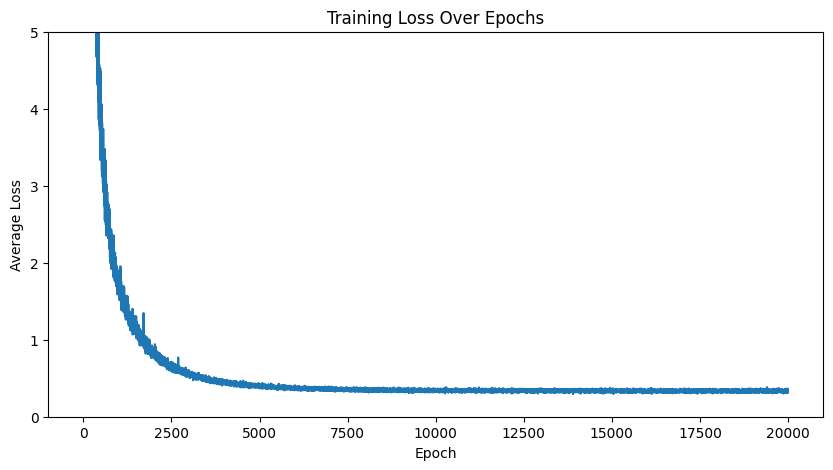

In [8]:
# plot loss curve
import numpy as np
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(batch_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.ylim(0, 5)  # Set y-axis limits between 0 and 1
plt.show()

Now, having a trained model, we want to check its in-context learning behavior. By having two weight vectors $w_1, w_2$, we hope to shuffle the portions of the two weight vectors in the in context prompt.

In [9]:
def test_in_context_learning(model, x_dim, y_dim, num_runs=50, L=50):
    model.eval()
    device = next(model.parameters()).device
    mse_loss = nn.MSELoss(reduction='mean')

    proportions = np.arange(0, 1.1, 0.1)  # 0 to 1.0 in steps of 0.1
    all_losses_w1 = []
    all_losses_w2 = []

    for _ in range(num_runs):
        losses_w1 = []
        losses_w2 = []

        for prop in proportions:
            num1 = int(L * prop)
            num2 = L - num1

            ds1 = MyDataset(x_dim, y_dim, 1, L=num1)
            ds2 = MyDataset(x_dim, y_dim, 1, L=num2)

            x1, y1, w1 = ds1[0]
            x2, y2, w2 = ds2[0]

            x1, y1, w1 = x1.to(device), y1.to(device), w1.to(device)
            x2, y2, w2 = x2.to(device), y2.to(device), w2.to(device)

            xs = torch.cat([x1, x2], dim=0)
            ys = torch.cat([y1, y2], dim=0)

            perm = torch.randperm(L, device=device)
            xs = xs[perm]
            ys = ys[perm]

            xs_big = torch.cat([xs, torch.zeros(L, y_dim, device=device)], dim=-1)
            ys_big = torch.cat([torch.zeros(L, x_dim, device=device), ys], dim=-1)

            # Interelaved
            zs_big = torch.cat([xs_big, ys_big], dim=-1).view(2*L, x_dim+y_dim)

            # both w1 and w2
            x_test = torch.rand(x_dim, device=device) * 2 - 1
            y_true_w1 = x_test @ w1
            y_true_w2 = x_test @ w2
            # y_guess = prop * y_true_w1 + (1 - prop) * y_true_w2
            y_guess = torch.zeros(y_dim, device=device)

            x_test_big = torch.cat([x_test, torch.zeros(y_dim, device=device)], dim=0).view(1, x_dim+y_dim)
            y_test_big = torch.cat([torch.zeros(1, x_dim, device=device), y_guess.view(1,y_dim)], dim=1)
            zs_test = torch.cat([x_test_big, y_test_big], dim=0)

            zs_all = torch.cat([zs_big, zs_test.view(2,x_dim+y_dim)], dim=0)

            # print(f"zs_all {zs_all.shape}")
            # print(zs_all)
            # break

            # Get model predictions
            with torch.no_grad():
                out = model(zs_all.view(1, 2*L + 2, x_dim+y_dim))

            y_pred = out[0, -2, -y_dim:]

            loss_w1 = mse_loss(y_pred, y_true_w1).item()
            loss_w2 = mse_loss(y_pred, y_true_w2).item()

            # print(loss_w1, loss_w2)
            # break

            losses_w1.append(loss_w1)
            losses_w2.append(loss_w2)

        # print(losses_w1)
        # print(losses_w2)
        # break
        all_losses_w1.append(losses_w1)
        all_losses_w2.append(losses_w2)

    # Calculate average losses across all runs
    # print(all_losses_w1)
    avg_losses_w1 = np.mean(all_losses_w1, axis=0)
    avg_losses_w2 = np.mean(all_losses_w2, axis=0)

    return avg_losses_w1, avg_losses_w2

# Run the test
avg_losses_w1, avg_losses_w2 = test_in_context_learning(model, x_dim, y_dim)

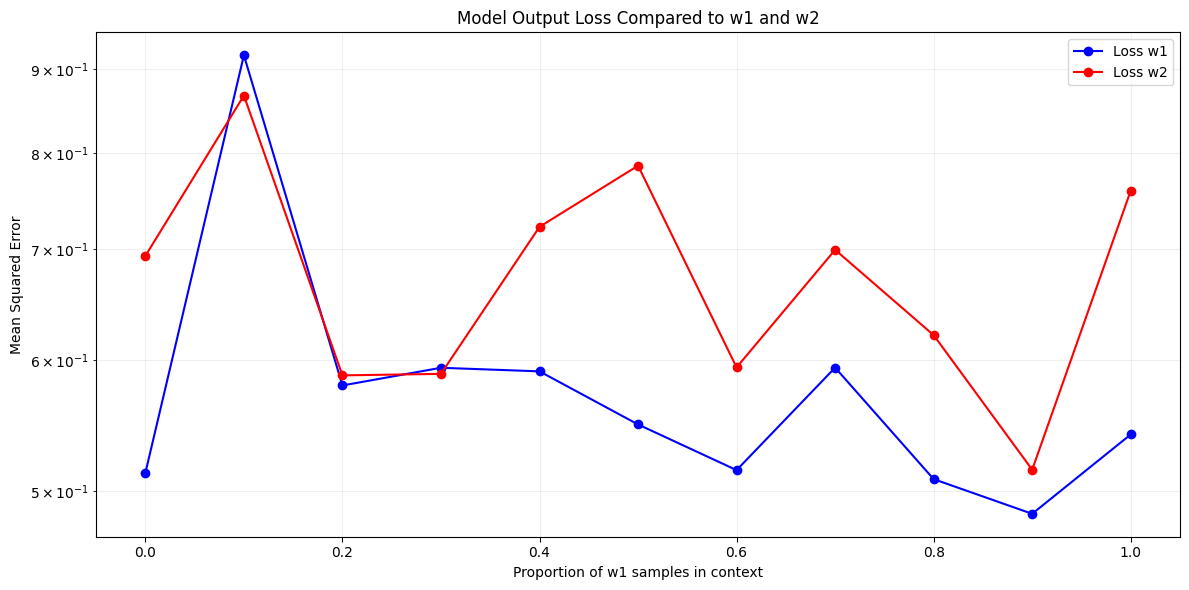

Average losses for w1: ['0.5126', '0.9173', '0.5790', '0.5935', '0.5905', '0.5484', '0.5146', '0.5936', '0.5082', '0.4842', '0.5408']
Average losses for w2: ['0.6935', '0.8672', '0.5872', '0.5885', '0.7222', '0.7865', '0.5938', '0.6995', '0.6211', '0.5149', '0.7596']


In [10]:
proportions = np.arange(0, 1.1, 0.1)  # 0 to 1.0 in steps of 0.1

plt.figure(figsize=(12, 6))
plt.plot(proportions, avg_losses_w1, label='Loss w1', color='blue', marker='o')
plt.plot(proportions, avg_losses_w2, label='Loss w2', color='red', marker='o')
plt.xlabel('Proportion of w1 samples in context')
plt.ylabel('Mean Squared Error')
plt.title('Model Output Loss Compared to w1 and w2')
plt.legend()
plt.yscale('log')  # Use log scale for y-axis to better visualize differences
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

print("Average losses for w1:", [f"{loss:.4f}" for loss in avg_losses_w1])
print("Average losses for w2:", [f"{loss:.4f}" for loss in avg_losses_w2])

